In [1]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
import pickle
import os

In [2]:
# **Step 1: Load the trained model**
model_path = './mood_prediction_model.pth'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"{model_path} not found. Ensure the model is saved in the correct directory.")


In [3]:
# Define the model structure (must match the structure during training)
class MoodPredictorNN(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(MoodPredictorNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, num_classes)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [4]:
# Load model parameters
input_size = 12  # Match the number of features used during training
num_classes = 4  # Replace with the number of unique mood labels in your training data
loaded_model = MoodPredictorNN(input_size, num_classes)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()

C:\Users\tpete\AppData\Local\Temp\ipykernel_23564\896959682.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path))


MoodPredictorNN(
  (fc1): Linear(in_features=12, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
  (relu): ReLU()
)

In [6]:
# **Step 2: Load and preprocess the metadata dataset**
metadata_path = './metadata_dataset.csv'
if not os.path.exists(metadata_path):
    raise FileNotFoundError(f"{metadata_path} not found. Ensure the file exists in the correct directory.")

metadata_df = pd.read_csv(metadata_path)


In [7]:
# Preprocess metadata features
columns_to_keep = [
    'popularity', 'duration_ms', 'danceability', 'energy', 'key',
    'loudness', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo'
]

In [8]:
# Ensure only the features used during training are selected
metadata_features = metadata_df[columns_to_keep]

In [9]:
# **Step 3: Load the scaler and label encoder**
scaler_path = './scaler.pkl'
label_encoder_path = './label_encoder.pkl'
if not os.path.exists(scaler_path) or not os.path.exists(label_encoder_path):
    raise FileNotFoundError("Scaler or LabelEncoder file not found. Ensure they are saved correctly during training.")

scaler = joblib.load(scaler_path)
with open(label_encoder_path, 'rb') as f:
    label_encoder = pickle.load(f)


In [10]:
# Apply the scaler
metadata_features_scaled = scaler.transform(metadata_features)


In [11]:
# Convert to PyTorch tensor
metadata_tensor = torch.tensor(metadata_features_scaled, dtype=torch.float32)


In [12]:
# **Step 4: Predict moods**
with torch.no_grad():
    outputs = loaded_model(metadata_tensor)
    _, predicted_moods = torch.max(outputs, 1)


In [13]:
# Map predictions back to labels
predicted_mood_labels = label_encoder.inverse_transform(predicted_moods.numpy())
metadata_df['predicted_mood'] = predicted_mood_labels


In [14]:
# **Step 5: Output playlists to the terminal**
for mood in metadata_df['predicted_mood'].unique():
    print(f"\nPlaylist for mood: {mood}")
    print(metadata_df[metadata_df['predicted_mood'] == mood][['track_name', 'artists', 'album_name']])


Playlist for mood: happy
                  track_name                    artists  \
0                     Comedy                Gen Hoshino   
5       Days I Will Remember               Tyrone Wells   
7                  I'm Yours                 Jason Mraz   
8                      Lucky  Jason Mraz;Colbie Caillat   
12                      Solo                   Dan Berk   
...                      ...                        ...   
113867            Petit pays              Cesária Evora   
113942         Beijo Roubado              Cesária Evora   
113946            Petit Pays              Cesária Evora   
113997        Miss Perfumado              Cesária Evora   
113999             Barbincor              Cesária Evora   

                                 album_name  
0                                    Comedy  
5                      Days I Will Remember  
7       We Sing. We Dance. We Steal Things.  
8       We Sing. We Dance. We Steal Things.  
12                                 

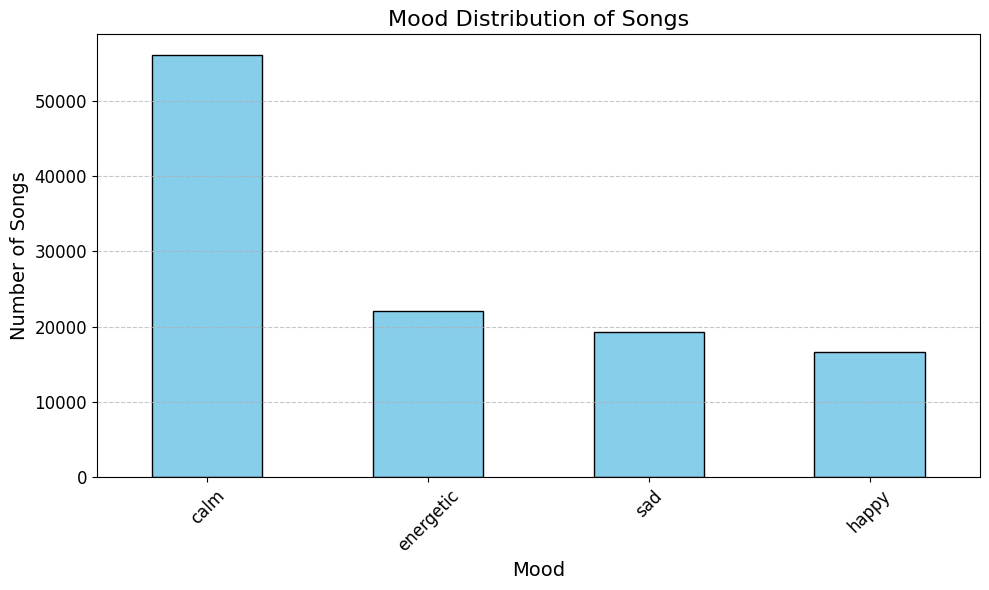

In [15]:
import matplotlib.pyplot as plt

# Count the number of songs per mood
mood_counts = metadata_df['predicted_mood'].value_counts()

# Plot the mood distribution
plt.figure(figsize=(10, 6))
mood_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Mood Distribution of Songs', fontsize=16)
plt.xlabel('Mood', fontsize=14)
plt.ylabel('Number of Songs', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
import random

# Function to display a playlist based on user-selected mood
def generate_user_playlist():
    # Get the list of unique moods
    moods = metadata_df['predicted_mood'].unique()

    # Display mood options
    print("Available moods:")
    # 1 - happy, 2 - sad, 3 - calm, 4 - energetic
    for idx, mood in enumerate(moods, 1):
        print(f"{idx}. {mood}")

    # Prompt user to select a mood
    while True:
        try:
            user_choice = int(input("\nEnter the number corresponding to your mood choice: "))
            if 1 <= user_choice <= len(moods):
                selected_mood = moods[user_choice - 1]
                break
            else:
                print("Invalid choice. Please select a valid number.")
        except ValueError:
            print("Please enter a number.")

    # Filter songs based on the selected mood
    mood_playlist = metadata_df[metadata_df['predicted_mood'] == selected_mood]

    # Randomly select 10 songs (or fewer if less available)
    num_songs = min(10, len(mood_playlist))
    selected_songs = mood_playlist.sample(n=num_songs)

    # Display the playlist
    print(f"\nPlaylist for mood: {selected_mood}")
    print(selected_songs[['track_name', 'artists', 'album_name']])

# Call the function to generate the playlist
generate_user_playlist()

Available moods:
1. happy
2. sad
3. calm
4. energetic

Playlist for mood: happy
                        track_name                      artists  \
66547   Hola Amigo - Hello Friends              Basho & Friends   
112099                  Ay Şarkısı                        Saian   
108175        Miehen mittainen tie                Jaska Mäkynen   
1736                    Boulmamine             Orchestra Baobab   
15905                     COLORWAY                DESTIN CONRAD   
1974               Tropical Garden                 Manu Dibango   
12738                         千個太陽  Deanie Ip;Elisa Chan;散芬芳合唱團   
67816                    Sin Carné                     Bad Gyal   
21302                 Mad Over You                      Runtown   
96296   Mutirão de amor - Ao vivo  Jorge Aragão;Zeca Pagodinho   

                     album_name  
66547                   aún más  
112099               Ay Şarkısı  
108175             Espanjan Yöt  
1736                      Bamba  
15905       

In [17]:
import random

# Function to generate and return the playlist (just song names)
def generate_user_playlist():
    # Get the list of unique moods
    moods = metadata_df['predicted_mood'].unique()

    # Display mood options
    print("Available moods:")
    for idx, mood in enumerate(moods, 1):
        print(f"{idx}. {mood}")

    # Prompt user to select a mood
    while True:
        try:
            user_choice = int(input("\nEnter the number corresponding to your mood choice: "))
            if 1 <= user_choice <= len(moods):
                selected_mood = moods[user_choice - 1]
                break
            else:
                print("Invalid choice. Please select a valid number.")
        except ValueError:
            print("Please enter a valid number.")

    # Filter songs based on the selected mood
    mood_playlist = metadata_df[metadata_df['predicted_mood'] == selected_mood]

    # Randomly select 10 songs (or fewer if less available)
    num_songs = min(10, len(mood_playlist))
    selected_songs = mood_playlist.sample(n=num_songs)

    # Get only the song names
    song_names = selected_songs['track_name'].tolist()

    # Display the playlist to the user
    print(f"\nPlaylist for mood: {selected_mood}")
    for i, song in enumerate(song_names, 1):
        print(f"{i}. {song}")

    # Return the song names as a list
    return song_names

# Call the function and capture the song names
playlist_songs = generate_user_playlist()


Available moods:
1. happy
2. sad
3. calm
4. energetic

Playlist for mood: happy
1. Bocat
2. Bloody Mary Morning
3. В парке Чаир
4. Coco
5. 愛情的腳步聲
6. Mandela You're Free
7. Warm Up
8. That's the Way Love Is - Deep House Mix-Extended Version
9. World Gone Crazy
10. Don’t Let Me Down - First Rooftop Performance


In [ ]:
import random

# Function to generate and return a playlist
def generate_user_playlist():
    # Get the list of unique moods
    moods = metadata_df['predicted_mood'].unique()

    # Display mood options
    print("Available moods:")
    # 1 - happy, 2 - sad, 3 - calm, 4 - energetic
    for idx, mood in enumerate(moods, 1):
        print(f"{idx}. {mood}")

    # Prompt user to select a mood
    while True:
        try:
            user_choice = int(input("\nEnter the number corresponding to your mood choice: "))
            if 1 <= user_choice <= len(moods):
                selected_mood = moods[user_choice - 1]
                break
            else:
                print("Invalid choice. Please select a valid number.")
        except ValueError:
            print("Please enter a valid number.")

    # Filter songs based on the selected mood
    mood_playlist = metadata_df[metadata_df['predicted_mood'] == selected_mood]

    # Randomly select 10 songs (or fewer if less available)
    num_songs = min(10, len(mood_playlist))
    selected_songs = mood_playlist.sample(n=num_songs)

    # Display the playlist with relevant columns
    print(f"\nPlaylist for mood: {selected_mood}")
    for i, row in selected_songs.iterrows():
        print(f"{i+1}. {row['track_name']} by {row['artists']} from the album '{row['album_name']}'")

    # Return the playlist as a DataFrame for further use if needed
    return selected_songs[['track_name', 'artists', 'album_name']]

# Call the function and capture the playlist
playlist_info = generate_user_playlist()


Available moods:
1. happy
2. sad
3. calm
4. energetic

Playlist for mood: sad
107934. Boulevard des Capucines - 2011 Remaster by Étienne Daho from the album 'L'invitation (2011 Remaster)'
99374. Work Song by Hozier from the album 'Hozier'
15434. ANGEL by keshi from the album 'GABRIEL'
101673. Air Conditioner - Loopable With No Fade - Baby Sleep by Vacuum Cleaner White Noise;Baby Sweet Dream from the album 'Soothing Sleeping Sounds'
75372. Sacred Head Wounded / Power of the Cross / There Is a Fountain by David Carnes from the album 'Journey...a Praise Offering'
97301. Filho Adotivo by Sérgio Reis e Filhos from the album 'Violas e Violeiros'
101133. Where the Waters Meet (O Waly, Waly) [Arr. C.B. Chambers for Wind Symphony] [Live] by Traditional;Mansfield Wind Symphony;Jeff King from the album '2021 Midwest Clinic: Mansfield Wind Symphony (Live)'
16560. Lakshmi Ashtothram by M. S. Subbulakshmi from the album 'M S Subbulakshmi Radio Recitals,Vol. 4'
39027. Orchestral Suite No. 3 in D Majo

In [ ]:
# Call the function and capture the playlist
playlist_info = generate_user_playlist()

Available moods:
1. happy
2. sad
3. calm
4. energetic

Playlist for mood: energetic
51517. Designer by Guru Randhawa;Yo Yo Honey Singh;Divya Khosla Kumar from the album 'Designer'
97890. Então Me Pega (feat. Diego & Arnaldo) - Ao Vivo by João Pedro e Cristiano;Diego & Arnaldo from the album 'Então Me Pega (feat. Diego & Arnaldo) [Ao Vivo]'
86732. Unos Pocos Peligros Sensatos by Patricio Rey y sus Redonditos de Ricota from the album 'Gulp!'
61913. あらかじめ語られるロマンス by Nogizaka46 from the album '命は美しい'
23652. On My Mind by Disciples from the album 'On My Mind'
112341. Fare Kapanı by Allame from the album 'Fare Kapanı'
92730. Bad News From Pretty Red Lips by Fatboy from the album 'Bad News From Pretty Red Lips'
35643. Que Sorte a Nossa by Silvanno Salles from the album 'O Cantor Apaixonado Volume 20'
36600. 500 connards sur la ligne de départ by Renaud from the album 'Marchand de cailloux'
9411. A Divina Comédia 2 by Rap Box;Fabio Brazza;Léo Casa 1;Gigante No Mic;Mano Fler;Zeus from the album

In [ ]:
import random

# Function to generate and return a playlist
def generate_user_playlist():
    # Get the list of unique moods
    moods = metadata_df['predicted_mood'].unique()

    # Display mood options
    print("Select a mood:")
    # 1 - happy, 2 - sad, 3 - calm, 4 - energetic
    for idx, mood in enumerate(moods, 1):
        print(f"{idx}. {mood}")

    # Prompt user to select a mood
    while True:
        try:
            user_choice = int(input("\nEnter the number corresponding to your mood choice: "))
            if 1 <= user_choice <= len(moods):
                selected_mood = moods[user_choice - 1]
                break
            else:
                print("Invalid choice. Please select a valid number.")
        except ValueError:
            print("Please enter a valid number.")

    # Filter songs based on the selected mood
    mood_playlist = metadata_df[metadata_df['predicted_mood'] == selected_mood]

    # Randomly select 10 songs from the mood category selected
    num_songs = min(10, len(mood_playlist))
    selected_songs = mood_playlist.sample(n=num_songs)

    # Display the playlist with relevant columns
    print(f"\nPlaylist for mood: {selected_mood}")
    for i, row in selected_songs.iterrows():
        print(f"{i+1}. {row['track_name']} By: {row['artists']} Album: '{row['album_name']}'")

    # Returns playlist as df for furture use
    return selected_songs[['track_name', 'artists', 'album_name']]

# Call the function, get playlist
playlist_info = generate_user_playlist()